In [ ]:
import os
from pathlib import Path
import pickle
import numpy as np
import pandas as pd
from glob import glob

In [ ]:
data_file = r"drive/MyDrive/facial-1018-all-data-column.pkl"
with open(data_file, "rb") as f:
  data = pickle.load(f)

In [ ]:
def split_and_reshape(dd, seq_length):
    # given dict, return (-1,10,323), (-1,5)

    # for x, split in seq size of seq_length
    x = dd['features']    # (-1,328)

    # extract the data part (0-frame, 1-face_id, 2-timestamp, 3-confidence, 4-success, gaze_0_x...)

    # filter to data with high confidence and success
    condition = (x[:,3]> 0.9) & (x[:,4]> 0.99)
    x = x[condition]
    x = x[:, 5:]  # get only feature information (from gaze_0_x...)
    x = x[30*30:, :] # discard the first 12s
    dim = x.shape[1]

    # take multiple of seq_length
    seq_num = int(x.shape[0]/seq_length)
    x = x[:seq_num*seq_length]
    # assert x.shape[1]== 323, "Expected shape of (-1,323) for feature"
    x = x.reshape((-1,seq_length,dim))

    # for y, replicate of each sequence
    # y = np.array([value for key, value in dd.items() if key != 'features'])  # (5,)
    y = np.array([dd['delay'], dd['jitter'], dd['packet_loss_rate']])
    y = np.tile(y, (seq_num,1))

    return x, y

def convert_to_seq_feature(data, seq_length=10):
    x_list, y_list = [], []
    for d in data:
        x,y = split_and_reshape(d, seq_length)   # return (-1,seq_length,323), (-1,5)
        x_list.append(x)
        y_list.append(y)

    # append along the first dimension
    X = np.concatenate(x_list, axis=0)
    Y = np.concatenate(y_list, axis=0)
    return X, Y

In [ ]:
X, Y = convert_to_seq_feature(data, seq_length=30)
X.shape, Y.shape

((25428, 30, 323), (25428, 3))

In [ ]:
for i in range(0,3):
  print(i,set(Y[:,i]))

0 {1000, 0, 500}
1 {0, 500}
2 {0, 30, 15}


In [ ]:
# encode categories
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Discretize each feature into bins
delay_bins = pd.cut(Y[:, 0], bins=3, labels=False)
jitter_bins = pd.cut(Y[:, 1], bins=3, labels=False)
package_loss_bins = pd.cut(Y[:, 2], bins=3, labels=False)

# Initialize LabelEncoders for each feature
delay_encoder = LabelEncoder()
jitter_encoder = LabelEncoder()
package_loss_encoder = LabelEncoder()

# Fit and transform the binned values
delay_encoded = delay_encoder.fit_transform(delay_bins)
jitter_encoded = jitter_encoder.fit_transform(jitter_bins)
package_loss_encoded = package_loss_encoder.fit_transform(package_loss_bins)

# Combine the encoded values
Y_encoded = np.stack((delay_encoded, jitter_encoded, package_loss_encoded), axis=1)

In [ ]:
for i in range(0,3):
  print(i,set(Y_encoded[:,i]))

0 {0, 1, 2}
1 {0, 1}
2 {0, 1, 2}


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoders for each feature
delay_encoder = LabelEncoder()
jitter_encoder = LabelEncoder()
package_loss_encoder = LabelEncoder()

# Fit and transform the binned values
delay_encoded = delay_encoder.fit_transform(delay_bins)
jitter_encoded = jitter_encoder.fit_transform(jitter_bins)
package_loss_encoded = package_loss_encoder.fit_transform(package_loss_bins)

# Combine the encoded values
Y_encoded = np.stack((delay_encoded, jitter_encoded, package_loss_encoded), axis=1)

In [ ]:
for i in range(0,3):
  print(i,set(Y_encoded[:,i]))

0 {0, 1, 2}
1 {0, 1}
2 {0, 1, 2}


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# prepare dataset
X_train, X_val, Y_train, Y_val = train_test_split(X, Y_encoded, test_size=0.1, random_state=42)
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

((22885, 30, 323), (22885, 3), (2543, 30, 323), (2543, 3))

In [ ]:
# Reshape the data to 2D for normalization
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_val_reshaped = X_val.reshape(-1, X_val.shape[-1])

# Standardize the data
scaler = StandardScaler()
X_train_reshaped = scaler.fit_transform(X_train_reshaped)
X_val_reshaped = scaler.transform(X_val_reshaped)

# Reshape back to the original shape
X_train = X_train_reshaped.reshape(X_train.shape)
X_val = X_val_reshaped.reshape(X_val.shape)
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

((22885, 30, 323), (22885, 3), (2543, 30, 323), (2543, 3))

In [ ]:
def create_model():
  # Define the input layer
  input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))  # Replace input_dim with your input dimension

  gru_1 = GRU(128, return_sequences=True)(input_layer)
  batch_1 = BatchNormalization()(gru_1)
  gru_2 = GRU(64, return_sequences=False)(batch_1)
  batch_2 = BatchNormalization()(gru_2)
  dense_1 = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(batch_2)
  drop_1 = tf.keras.layers.Dropout(0.2)(dense_1)
  dense_2 = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(drop_1)
  drop_2 = tf.keras.layers.Dropout(0.2)(dense_2)
  hidden_layer = drop_2

  # Define separate output layers for each feature
  output_delay = Dense(3, activation='softmax', name='delay_output')(hidden_layer)  # 3 categories for delay
  output_jitter = Dense(2, activation='softmax', name='jitter_output')(hidden_layer)        # 2 categories for jitter
  output_packet_loss = Dense(3, activation='softmax', name='packet_loss_output')(hidden_layer)  # 3 categories for packet loss

  # Define the model with multiple outputs
  model = Model(inputs=input_layer, outputs=[output_delay, output_jitter, output_packet_loss])

  # Compile the model
  model.compile(optimizer='adam',
                  loss={'delay_output': 'SparseCategoricalCrossentropy',
                        'jitter_output': 'SparseCategoricalCrossentropy',
                        'packet_loss_output': 'SparseCategoricalCrossentropy'},
                  metrics=['accuracy'])

  return model

model = create_model()

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 30, 323)]            0         []                            
                                                                                                  
 gru (GRU)                   (None, 30, 128)              173952    ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 30, 128)              512       ['gru[0][0]']                 
 Normalization)                                                                                   
                                                                                                  
 gru_1 (GRU)                 (None, 64)                   37248     ['batch_normalization[0][0

In [ ]:
from tensorflow.keras.callbacks import TensorBoard
import datetime
import matplotlib.pyplot as plt

In [ ]:
current_timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
log_dir = f'drive/MyDrive/tensorflow_logs_1026_{current_timestamp}'
print(log_dir)
tensorboard_callback = TensorBoard(log_dir=log_dir)

drive/MyDrive/tensorflow_logs_1026_20240520_031539


In [ ]:
early_stopping = EarlyStopping(monitor='loss', patience=20, restore_best_weights=True)

In [ ]:
history_list = []
def fit():
  history = model.fit(X_train, [Y_train[:,0], Y_train[:,1], Y_train[:,2]],
          epochs = 500,
          batch_size=32,
          validation_data = (X_val, [Y_val[:,0], Y_val[:,1], Y_val[:,2]]),
          callbacks=[tensorboard_callback, early_stopping]
  )
  history_list.append(history)
  return history

In [ ]:
fit()

Epoch 1/500
716/716 [==============================] - 16s 12ms/step - loss: 3.2134 - delay_output_loss: 1.0564 - jitter_output_loss: 0.6668 - packet_loss_output_loss: 1.0934 - delay_output_accuracy: 0.4144 - jitter_output_accuracy: 0.6114 - packet_loss_output_accuracy: 0.3768 - val_loss: 2.9334 - val_delay_output_loss: 1.0452 - val_jitter_output_loss: 0.6525 - val_packet_loss_output_loss: 1.0725 - val_delay_output_accuracy: 0.4298 - val_jitter_output_accuracy: 0.6304 - val_packet_loss_output_accuracy: 0.4133
Epoch 2/500
716/716 [==============================] - 7s 10ms/step - loss: 2.8093 - delay_output_loss: 1.0201 - jitter_output_loss: 0.6400 - packet_loss_output_loss: 1.0600 - delay_output_accuracy: 0.4402 - jitter_output_accuracy: 0.6426 - packet_loss_output_accuracy: 0.4260 - val_loss: 2.7382 - val_delay_output_loss: 1.0142 - val_jitter_output_loss: 0.6325 - val_packet_loss_output_loss: 1.0409 - val_delay_output_accuracy: 0.4542 - val_jitter_output_accuracy: 0.6481 - val_packet_

In [ ]:
def plot_history(history):
    plt.figure(figsize=(10, 6))

    # Plot training & validation loss values
    plt.subplot(2, 2, 1)
    plt.plot(history['loss'], label='Training Loss')
    if 'val_loss' in history:
        plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    # Plot training & validation delay_output accuracy values
    plt.subplot(2, 2, 2)
    plt.plot(history['delay_output_accuracy'], label='Training Delay Accuracy')
    if 'val_delay_output_accuracy' in history:
        plt.plot(history['val_delay_output_accuracy'], label='Validation Delay Accuracy')
    plt.title('Delay Output Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Plot training & validation jitter_output accuracy values
    plt.subplot(2, 2, 3)
    plt.plot(history['jitter_output_accuracy'], label='Training Jitter Accuracy')
    if 'val_jitter_output_accuracy' in history:
        plt.plot(history['val_jitter_output_accuracy'], label='Validation Jitter Accuracy')
    plt.title('Jitter Output Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Plot training & validation packet_loss_output accuracy values
    plt.subplot(2, 2, 4)
    plt.plot(history['packet_loss_output_accuracy'], label='Training Packet Loss Accuracy')
    if 'val_packet_loss_output_accuracy' in history:
        plt.plot(history['val_packet_loss_output_accuracy'], label='Validation Packet Loss Accuracy')
    plt.title('Packet Loss Output Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

def combine_histories(history_list):
    combined_history = {}
    for history in history_list:
        for key, values in history.history.items():
            if key not in combined_history:
                combined_history[key] = values
            else:
                combined_history[key].extend(values)
    return combined_history

def plot_():
  plot_history(combine_histories(history_list))


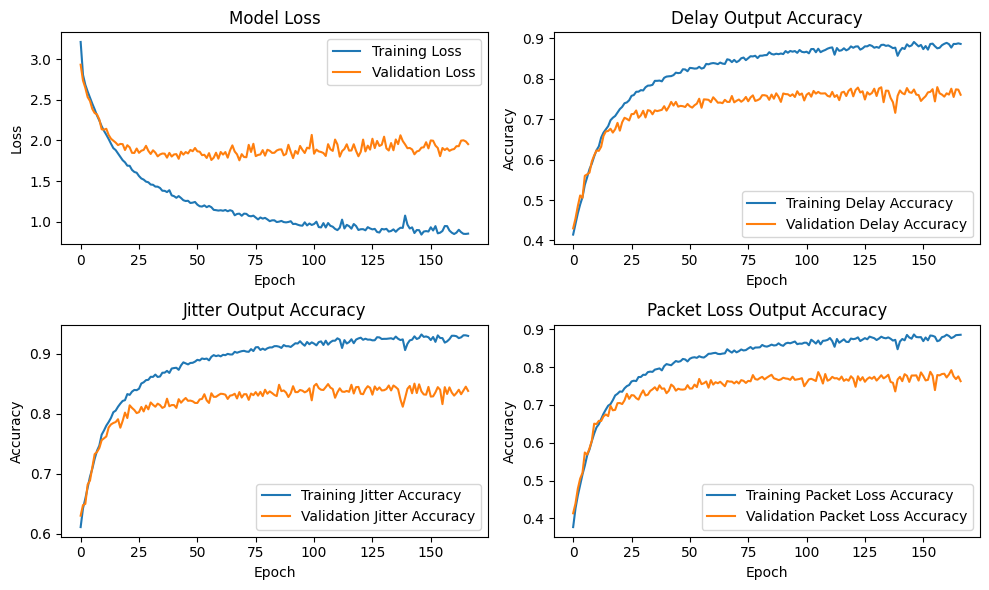

In [ ]:
plot_()

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir drive/MyDrive/tensorflow_logs_20240519_144352